--- Plotting Loss Curve from /home/s2behappy4/data/gyuhyeong/MLLM_Anomaly/nohup.out ---


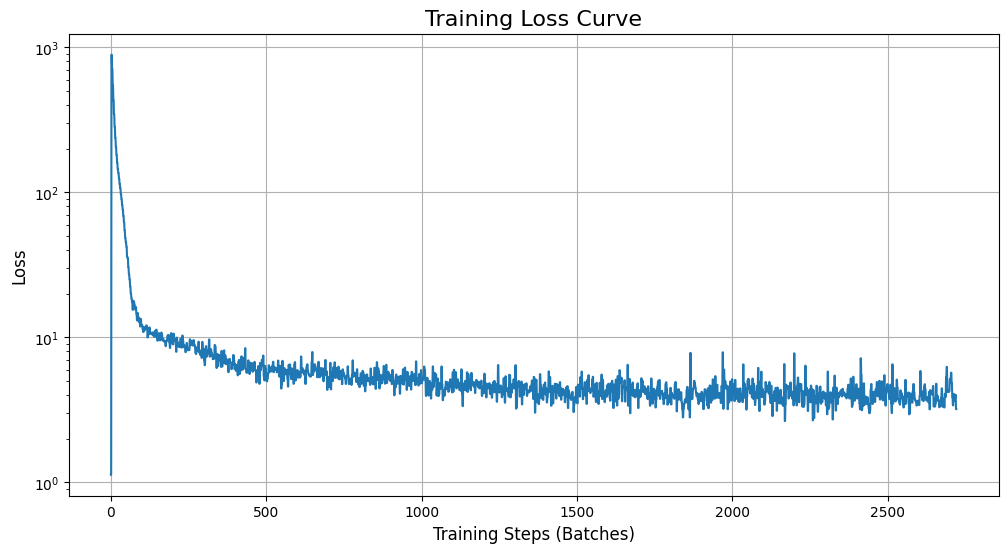


--- Generating t-SNE Visualization ---


Generating mask tokens for t-SNE: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 571.01it/s]


t-SNE transformation complete.


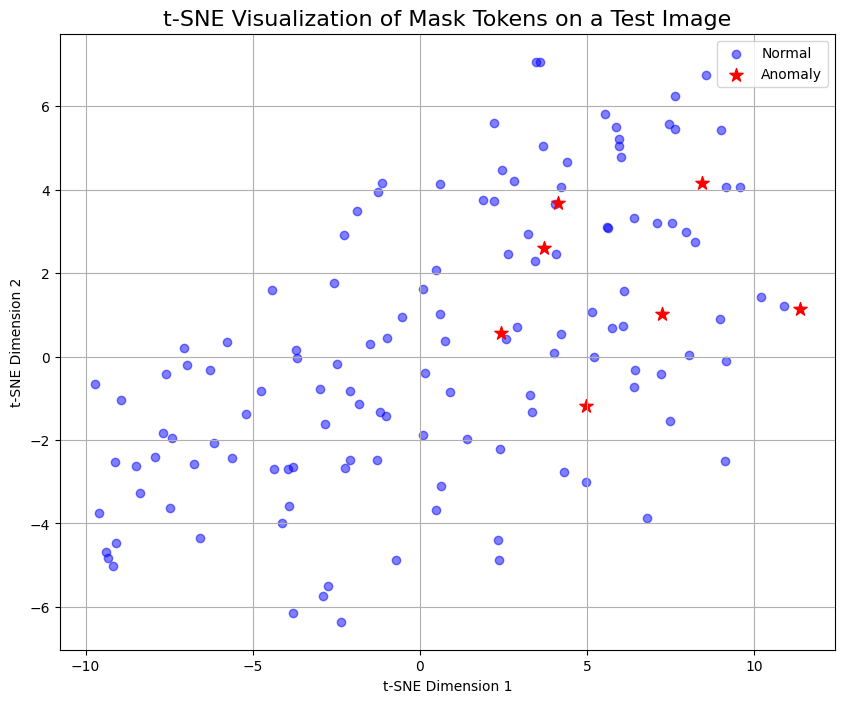

In [1]:
import torch
import torch.nn as nn
import os
import pickle
import json
import math
import re
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

class PixelProjectionLayer(nn.Module):
    def __init__(self, input_dim=3, output_dim=256):
        super().__init__()
        self.proj = nn.Conv2d(input_dim, output_dim, kernel_size=1)
    def forward(self, x):
        return self.proj(x)

class FourierPositionalEncoding(nn.Module):
    def __init__(self, hidden_dim: int, height: int, width: int):
        super().__init__()
        if hidden_dim % 4 != 0: raise ValueError(f"hidden_dim {hidden_dim} must be divisible by 4")
        num_bands = hidden_dim // 4
        bands = torch.pow(2.0, torch.arange(num_bands, dtype=torch.float32))
        y_pos, x_pos = torch.linspace(-1, 1, height, dtype=torch.float32), torch.linspace(-1, 1, width, dtype=torch.float32)
        y_args, x_args = y_pos[:, None] * bands[None, :], x_pos[:, None] * bands[None, :]
        y_emb, x_emb = torch.cat([torch.sin(y_args), torch.cos(y_args)], dim=-1), torch.cat([torch.sin(x_args), torch.cos(x_args)], dim=-1)
        y_emb_expanded, x_emb_expanded = y_emb.unsqueeze(1).expand(-1, width, -1), x_emb.unsqueeze(0).expand(height, -1, -1)
        pos_encoding = torch.cat([y_emb_expanded, x_emb_expanded], dim=-1)
        self.register_buffer('pos_encoding', pos_encoding.permute(2, 0, 1).unsqueeze(0), persistent=False)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self.pos_encoding

class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, n_heads):
        super().__init__()
        self.cross_attn, self.self_attn = nn.MultiheadAttention(embed_dim, n_heads, batch_first=True), nn.MultiheadAttention(embed_dim, n_heads, batch_first=True)
        self.ffn = nn.Sequential(nn.Linear(embed_dim, embed_dim * 4), nn.GELU(), nn.Linear(embed_dim * 4, embed_dim))
        self.norm1, self.norm2, self.norm3 = nn.LayerNorm(embed_dim), nn.LayerNorm(embed_dim), nn.LayerNorm(embed_dim)
    def forward(self, query, mask_pixels):
        attn_output, _ = self.cross_attn(query=query, key=mask_pixels, value=mask_pixels); query = self.norm1(query + attn_output)
        attn_output, _ = self.self_attn(query=query, key=query, value=query); query = self.norm2(query + attn_output)
        ffn_output = self.ffn(query); query = self.norm3(query + ffn_output)
        return query

class MaskTokenizer(nn.Module):
    def __init__(self, embed_dim=256, n_heads=8, n_queries=4, n_layers=1):
        super().__init__()
        self.learnable_queries, self.decoder_layers, self.embed_dim = nn.Parameter(torch.randn(1, n_queries, embed_dim)), nn.ModuleList([TransformerDecoderLayer(embed_dim, n_heads) for _ in range(n_layers)]), embed_dim
    def forward(self, all_pixel_features, mask):
        mask_pixels = all_pixel_features[mask]
        if mask_pixels.shape[0] == 0: return torch.zeros(1, self.embed_dim, device=all_pixel_features.device)
        queries = self.learnable_queries.expand(1, -1, -1)
        for layer in self.decoder_layers: queries = layer(queries, mask_pixels.unsqueeze(0))
        return queries.mean(dim=1)

class Projector(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super().__init__(); self.fc1, self.activation, self.fc2, self.layer_norm = nn.Linear(input_dim, (input_dim + output_dim) // 2), nn.GELU(), nn.Linear((input_dim + output_dim) // 2, output_dim), nn.LayerNorm(output_dim)
    def forward(self, x: torch.Tensor) -> torch.Tensor: return self.layer_norm(self.fc2(self.activation(self.fc1(x))))

ANALYSIS_CONFIG = {
    "log_file_path": "/home/s2behappy4/data/gyuhyeong/MLLM_Anomaly/nohup.out", 
    "checkpoint_path": "/home/s2behappy4/data/gyuhyeong/MLLM_Anomaly/checkpoints/latest_checkpoint.pth",
    "test_image_path": "/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/grid/test/bent/000.png",
    "sam_cfg_path": "configs/sam2.1/sam2.1_hiera_l.yaml",
    "sam_ckpt_path": "./checkpoints/sam2.1_hiera_large.pt",
    "image_size": 512,
    "embed_dim": 256,
    "llm_hidden_dim": 4096,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
}

def plot_loss_curve(log_path):
    print(f"--- Plotting Loss Curve from {log_path} ---")
    try:
        with open(log_path, 'r') as f:
            log_content = f.read()

        losses = [float(x) for x in re.findall(r"loss=(\d+\.?\d*)", log_content)]
        
        if not losses:
            print("No loss values found in log file.")
            return

        plt.figure(figsize=(12, 6))
        plt.plot(losses)
        plt.title("Training Loss Curve", fontsize=16)
        plt.xlabel("Training Steps (Batches)", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.grid(True)
        plt.yscale('log')
        plt.show()
    except FileNotFoundError:
        print(f"Error: Log file not found at {log_path}")
    except Exception as e:
        print(f"An error occurred while plotting loss: {e}")

def generate_tsne_plot(config):
    print("\n--- Generating t-SNE Visualization ---")
    device = config["device"]

    pixel_proj_layer = PixelProjectionLayer(output_dim=config["embed_dim"]).to(device)
    mask_tokenizer = MaskTokenizer(embed_dim=config["embed_dim"]).to(device)
    projector = Projector(input_dim=config["embed_dim"], output_dim=config["llm_hidden_dim"]).to(device)
    checkpoint = torch.load(config["checkpoint_path"], map_location=device)
    pixel_proj_layer.load_state_dict(checkpoint['pixel_proj_layer_state_dict'])
    mask_tokenizer.load_state_dict(checkpoint['mask_tokenizer_state_dict'])
    projector.load_state_dict(checkpoint['projector_state_dict'])
    pixel_proj_layer.eval(); mask_tokenizer.eval(); projector.eval()

    from sam2.build_sam import build_sam2
    from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
    sam_model = build_sam2(config["sam_cfg_path"], config["sam_ckpt_path"], device=device)
    mask_generator = SAM2AutomaticMaskGenerator(model=sam_model, points_per_side=32, points_per_batch=64, pred_iou_thresh=0.90, stability_score_thresh=0.95, box_nms_thresh=0.1, crop_n_layers=0, point_grids=None, min_mask_region_area=10, output_mode="binary_mask", use_m2m=False, multimask_output=True)

    resize_transform = T.Resize((config["image_size"], config["image_size"]), interpolation=T.InterpolationMode.BICUBIC)
    normalize_transform = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    
    test_image_pil = Image.open(config["test_image_path"]).convert("RGB")
    test_image_resized_pil = resize_transform(test_image_pil)
    test_image_tensor = normalize_transform(test_image_resized_pil).to(device)
    test_image_cv = cv2.cvtColor(np.array(test_image_resized_pil), cv2.COLOR_RGB2BGR)

    raw_masks_data = mask_generator.generate(test_image_cv)
    raw_masks = [d['segmentation'] for d in raw_masks_data]
    h, w = raw_masks[0].shape
    areas = [m.sum() for m in raw_masks]; sorted_idx = np.argsort(areas)
    union_prev = np.zeros((h, w), dtype=bool); clean_masks = []
    for idx in sorted_idx:
        m, m_clean = raw_masks[idx], raw_masks[idx] & (~union_prev)
        if m_clean.sum() > 0: clean_masks.append(m_clean); union_prev |= m_clean
    inv_mask = ~union_prev.copy()
    if inv_mask.sum() >= 10: clean_masks.append(inv_mask)
    processed_masks = clean_masks

    pos_encoding_module = FourierPositionalEncoding(config["embed_dim"], config["image_size"], config["image_size"]).to(device)
    pixel_features_base = pixel_proj_layer(test_image_tensor.unsqueeze(0))
    pixel_features_pos = pos_encoding_module(pixel_features_base).squeeze(0).permute(1, 2, 0)
    all_mask_tokens = []
    with torch.no_grad():
        for mask_np in tqdm(processed_masks, desc="Generating mask tokens for t-SNE"):
            mask_tensor = torch.from_numpy(mask_np).to(device)
            mask_token = projector(mask_tokenizer(pixel_features_pos, mask_tensor))
            all_mask_tokens.append(mask_token)
            
    token_embeddings = torch.cat(all_mask_tokens, dim=0).cpu().numpy()

    tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42, n_jobs=-1)
    tsne_results = tsne.fit_transform(token_embeddings)
    print("t-SNE transformation complete.")

    from skimage.io import imread
    gt_path = config["test_image_path"].replace('/test/', '/ground_truth/').replace('.png', '_mask.png')
    
    if os.path.exists(gt_path):
        anomaly_gt_mask_original = imread(gt_path)
        anomaly_gt_mask = cv2.resize(
            anomaly_gt_mask_original, 
            (config["image_size"], config["image_size"]), 
            interpolation=cv2.INTER_NEAREST
        ) > 0 
    else:
        anomaly_gt_mask = np.zeros((h,w), dtype=bool)

    token_labels = ['anomaly' if np.any(mask & anomaly_gt_mask) else 'normal' for mask in processed_masks]

    plt.figure(figsize=(10, 8))
    for i, label in enumerate(token_labels):
        if label == 'normal':
            plt.scatter(tsne_results[i, 0], tsne_results[i, 1], c='blue', alpha=0.5, label='Normal' if 'Normal' not in plt.gca().get_legend_handles_labels()[1] else "")
        else: 
            plt.scatter(tsne_results[i, 0], tsne_results[i, 1], c='red', s=100, marker='*', label='Anomaly' if 'Anomaly' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.title('t-SNE Visualization of Mask Tokens on a Test Image', fontsize=16); plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2'); plt.legend(); plt.grid(True); plt.show()

if __name__ == "__main__":
    plot_loss_curve(ANALYSIS_CONFIG['log_file_path'])
    generate_tsne_plot(ANALYSIS_CONFIG)